In [337]:
import glob
import time

import ajf_utils
import BeamWithSprings as bm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ajf_bridge_fem import *
from scipy import optimize, stats

import ajf_noise_model
import ajf_plts

plt.style.use(["./ajf_plts/base.mplstyle", "./ajf_plts/legend_frame.mplstyle"])

In [338]:
MODEL = "GH"

In [339]:
if MODEL == "LB":
    beam = construct_model_LB()
    DOFS = [beam.x_pos_to_rot_dof(x) for x in [0, LB_span_length]]
    LOC_NAMES = ["L", "R"]
elif MODEL == "GH":
    beam = construct_model_GH()
    DOFS = [
        beam.x_pos_to_rot_dof(x)
        for x in [
            GH_side_span_length,
            GH_side_span_length + GH_center_span_length,
        ]
    ]
    LOC_NAMES = ["L_pier", "R_pier"]
else:
    raise Exception("Unknown model")

{0.0} & {20.9}& {$\num{1.0}$} & {$\num{1.0}$} \\
{0.1} & {20.9}& {$\num{1.0043}$} & {$\num{1.0043}$} \\
{0.2} & {20.9}& {$\num{1.0089}$} & {$\num{1.0089}$} \\


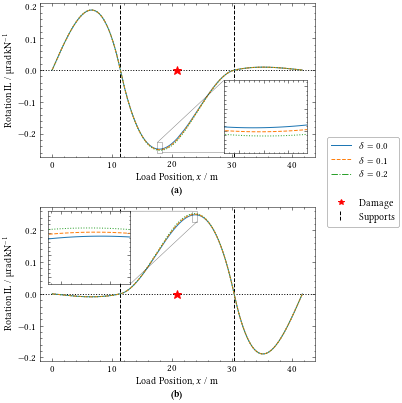

In [353]:
%matplotlib inline

fig, axes = plt.subplots(
    figsize=(ajf_plts.text_width_inches, 2.5 * ajf_plts.fig_height_inches),
    nrows=2,
    ncols=1,
)

axins = [
    axes[0].inset_axes([0.67, 0.03, 0.3, 0.47]),
    axes[1].inset_axes([0.03, 0.5, 0.3, 0.47]),
]

P = np.array([-1e3])
S = np.array([0.0])

DELTA_VALS = [0.0, 0.1, 0.2]
X_DAM = GH_side_span_length + GH_center_span_length / 2.0

beam.E = 30e9
beam.damp_ratio = 0.0
beam.reset_crack_damage()
beam.update_model()

# STATIC SIM
x, stat_healthy = beam.perform_static_sim(
    P,
    S,
    force_step=beam.L.sum() / 1000.0,
)

for delta in DELTA_VALS:
    beam.reset_crack_damage()
    beam.add_crack_damage(X_DAM, delta)
    beam.update_model()

    # STATIC SIM
    x, stat_disp = beam.perform_static_sim(
        P,
        S,
        force_step=beam.L.sum() / 1000.0,
    )

    print(f"{{{delta:.1f}}} & {{{X_DAM}}}", end="")
    for i, dof in enumerate(DOFS):
        IL = stat_disp[dof] * 1e6
        IL0 = stat_healthy[dof] * 1e6
        axes[i].plot(x, IL)
        axins[i].plot(x, IL)
        ind = np.argmax(np.abs(IL))
        axins[i].set_xlim([x[ind - 10], x[ind + 10]])
        axins[i].set_ylim(sorted([0.9 * IL[ind], 1.03 * IL[ind]]))
        print(f"& {{$\\num{{{np.ptp(IL) / np.ptp(IL0):00.5}}}$}} ", end="")
    print("\\\\")

for ax in np.concatenate([axes, axins]):
    ax.plot(X_DAM, 0.0, marker="*", markersize=9.0, ls="", c="r", zorder=10)

    ax.axhline(0.0, ls=":", c="k", zorder=-10)
    ax.axvline(GH_side_span_length, ls="--", c="k", zorder=-10)
    ax.axvline(GH_side_span_length + GH_center_span_length, ls="--", c="k", zorder=-10)

for ax, axin in zip(axes, axins):
    ax.set_xlabel(r"Load Position, $x$ / m")
    ax.set_ylabel(r"Rotation IL / $\unit{\micro\radian\per\kilo\newton}$")
    axin.set_xticklabels([])
    axin.set_yticklabels([])
    ax.indicate_inset_zoom(axin, edgecolor="black")


class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mpl.text.Text(x0, y0, orig_handle)
        handlebox.add_artist(title)
        return title


custom_lines = [
    mpl.lines.Line2D([0], [0], color="C0", ls="-", label="0.0"),
    mpl.lines.Line2D([0], [0], color="C1", ls="--", label="0.1"),
    mpl.lines.Line2D([0], [0], color="C2", ls="-.", label="0.2"),
    "",
    mpl.lines.Line2D([0], [0], color="r", ls="", marker="*", label="Damage Loc."),
    mpl.lines.Line2D(
        [0],
        [0],
        color="k",
        ls="--",
        label="Supports",
    ),
]

ax_fake = fig.add_subplot(111)
ax_fake.set_axis_off()
legend = ax_fake.legend(
    custom_lines,
    [
        r"$\delta=0.0$",
        r"$\delta=0.1$",
        r"$\delta=0.2$",
        "",
        "Damage",
        "Supports",
    ],
    handler_map={str: LegendTitle()},
    loc="center left",
    bbox_to_anchor=(1.025, 0.5),
)

l = legend.get_lines()[-1]
l.set_transform(
    l.get_transform().inverted()
    + mpl.transforms.Affine2D().rotate_deg(90).scale(1, 0.5).translate(13, 0)
    + l.get_transform()
)

ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, "fig-GH-RILwMidDamage.pdf")

{0.0} & {17.733333333333334}& {$\num{1.0}$} & {$\num{1.0}$} \\
{0.1} & {17.733333333333334}& {$\num{1.013}$} & {$\num{1.0002}$} \\
{0.2} & {17.733333333333334}& {$\num{1.029}$} & {$\num{1.0003}$} \\


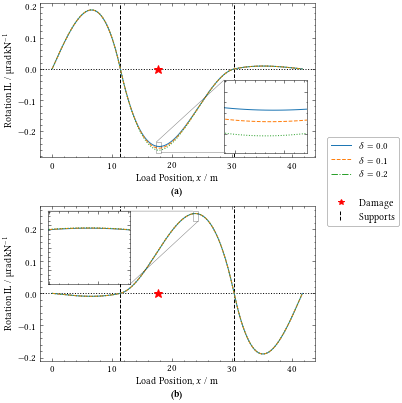

In [354]:
%matplotlib inline

fig, axes = plt.subplots(
    figsize=(ajf_plts.text_width_inches, 2.5 * ajf_plts.fig_height_inches),
    nrows=2,
    ncols=1,
)

axins = [
    axes[0].inset_axes([0.67, 0.03, 0.3, 0.47]),
    axes[1].inset_axes([0.03, 0.5, 0.3, 0.47]),
]

P = np.array([-1e3])
S = np.array([0.0])

DELTA_VALS = [0.0, 0.1, 0.2]
X_DAM = GH_side_span_length + GH_center_span_length / 3.0

beam.E = 30e9
beam.damp_ratio = 0.0
beam.reset_crack_damage()
beam.update_model()

# STATIC SIM
x, stat_healthy = beam.perform_static_sim(
    P,
    S,
    force_step=beam.L.sum() / 1000.0,
)

for delta in DELTA_VALS:
    beam.reset_crack_damage()
    beam.add_crack_damage(X_DAM, delta)
    beam.update_model()

    # STATIC SIM
    x, stat_disp = beam.perform_static_sim(
        P,
        S,
        force_step=beam.L.sum() / 1000.0,
    )

    print(f"{{{delta:.1f}}} & {{{X_DAM}}}", end="")
    for i, dof in enumerate(DOFS):
        IL = stat_disp[dof] * 1e6
        IL0 = stat_healthy[dof] * 1e6
        axes[i].plot(x, IL)
        axins[i].plot(x, IL)
        ind = np.argmax(np.abs(IL))
        axins[i].set_xlim([x[ind - 10], x[ind + 10]])
        axins[i].set_ylim(sorted([0.9 * IL[ind], 1.03 * IL[ind]]))
        print(f"& {{$\\num{{{np.ptp(IL) / np.ptp(IL0):00.5}}}$}} ", end="")
    print("\\\\")

for ax in np.concatenate([axes, axins]):
    ax.plot(X_DAM, 0.0, marker="*", markersize=9.0, ls="", c="r", zorder=10)

    ax.axhline(0.0, ls=":", c="k", zorder=-10)
    ax.axvline(GH_side_span_length, ls="--", c="k", zorder=-10)
    ax.axvline(GH_side_span_length + GH_center_span_length, ls="--", c="k", zorder=-10)

for ax, axin in zip(axes, axins):
    ax.set_xlabel(r"Load Position, $x$ / m")
    ax.set_ylabel(r"Rotation IL / $\unit{\micro\radian\per\kilo\newton}$")
    axin.set_xticklabels([])
    axin.set_yticklabels([])
    ax.indicate_inset_zoom(axin, edgecolor="black")


class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mpl.text.Text(x0, y0, orig_handle)
        handlebox.add_artist(title)
        return title


custom_lines = [
    mpl.lines.Line2D([0], [0], color="C0", ls="-", label="0.0"),
    mpl.lines.Line2D([0], [0], color="C1", ls="--", label="0.1"),
    mpl.lines.Line2D([0], [0], color="C2", ls="-.", label="0.2"),
    "",
    mpl.lines.Line2D([0], [0], color="r", ls="", marker="*", label="Damage Loc."),
    mpl.lines.Line2D(
        [0],
        [0],
        color="k",
        ls="--",
        label="Supports",
    ),
]

ax_fake = fig.add_subplot(111)
ax_fake.set_axis_off()
legend = ax_fake.legend(
    custom_lines,
    [
        r"$\delta=0.0$",
        r"$\delta=0.1$",
        r"$\delta=0.2$",
        "",
        "Damage",
        "Supports",
    ],
    handler_map={str: LegendTitle()},
    loc="center left",
    bbox_to_anchor=(1.025, 0.5),
)

l = legend.get_lines()[-1]
l.set_transform(
    l.get_transform().inverted()
    + mpl.transforms.Affine2D().rotate_deg(90).scale(1, 0.5).translate(13, 0)
    + l.get_transform()
)

ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, "fig-GH-RILwThirdDamage.pdf")